##### Copyright 2020 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow Probability on JAX

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/probability/examples/TensorFlow_Probability_on_JAX"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/TensorFlow_Probability_on_JAX.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/TensorFlow_Probability_on_JAX.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/probability/tensorflow_probability/examples/jupyter_notebooks/TensorFlow_Probability_on_JAX.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

TensorFlow Probability (TFP) is a library for probabilistic reasoning and statistical analysis that now also works on [JAX](https://github.com/google/jax)! For those not familiar, JAX is a library for accelerated numerical computing based on composable function transformations.

TFP on JAX supports a lot of the most useful functionality of regular TFP while preserving the abstractions and APIs that many TFP users are now comfortable with.

## Setup

TFP on JAX does **not** depend on TensorFlow; let's uninstall TensorFlow from this Colab entirely.

In [0]:
!pip uninstall tensorflow -y -q

We can install TFP on JAX with the latest nightly builds of TFP.

In [0]:
!pip install -Uq tfp-nightly[jax] > /dev/null

Let's import some useful Python libraries.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import datasets
sns.set(style='white')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Let's also import some basic JAX functionality.

In [0]:
import jax.numpy as jnp
from jax import grad
from jax import jit
from jax import random
from jax import value_and_grad
from jax import vmap

## Importing TFP on JAX

To use TFP on JAX, simply import the `jax` "substrate" and use it as you usually would `tfp`:

In [0]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

## Demo: Bayesian logistic regression

To demonstrate what we can do with the JAX backend, we'll implement Bayesian logistic regression applied to the classic Iris dataset.


First, let's import the Iris dataset and extract some metadata.



In [0]:
iris = datasets.load_iris()
features, labels = iris['data'], iris['target']

num_features = features.shape[-1]
num_classes = len(iris.target_names)

We can define the model using `tfd.JointDistributionCoroutine`. We'll put standard normal priors on both the weights and the bias term then write a `target_log_prob` function that pins the sampled labels to the data.

In [0]:
Root = tfd.JointDistributionCoroutine.Root
def model():
  w = yield Root(tfd.Sample(tfd.Normal(0., 1.),
                            sample_shape=(num_features, num_classes)))
  b = yield Root(
      tfd.Sample(tfd.Normal(0., 1.), sample_shape=(num_classes,)))
  logits = jnp.dot(features, w) + b
  yield tfd.Independent(tfd.Categorical(logits=logits),
                        reinterpreted_batch_ndims=1)


dist = tfd.JointDistributionCoroutine(model)
def target_log_prob(*params):
  return dist.log_prob(params + (labels,))

We sample from `dist` to produce an initial state for MCMC. We can then define a function that takes in a random key and an initial state, and produces 500 samples from a No-U-Turn-Sampler (NUTS). Note that we can use JAX transformations like `jit` to compile our NUTS sampler using XLA.

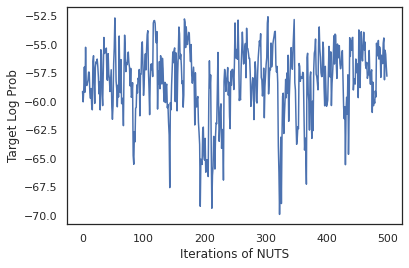

In [0]:
init_key, sample_key = random.split(random.PRNGKey(0))
init_params = tuple(dist.sample(seed=init_key)[:-1])

@jit
def run_chain(key, state):
  kernel = tfp.mcmc.NoUTurnSampler(target_log_prob, 1e-3)
  return tfp.mcmc.sample_chain(500,
      current_state=state,
      kernel=kernel,
      trace_fn=lambda _, results: results.target_log_prob,
      num_burnin_steps=500,
      seed=key)

states, log_probs = run_chain(sample_key, init_params)
plt.figure()
plt.plot(log_probs)
plt.ylabel('Target Log Prob')
plt.xlabel('Iterations of NUTS')
plt.show()

Let's use our samples to perform Bayesian model averaging (BMA) by averaging the predicted probabilies of each set of weights.

First let's write a function that for a given set of parameters will produce the probabilities over each class. We can use `dist.sample_distributions` to obtain the final distribution in the model.

In [0]:
def classifier_probs(params):
  dists, _ = dist.sample_distributions(seed=random.PRNGKey(0),
                                       value=params + (None,))
  return dists[-1].distribution.probs_parameter()

We can `vmap(classifier_probs)` over the set of samples to get the predicted class probabilities for each of our samples. We then compute the average accuracy across each sample, and the accuracy from Bayesian model averaging.

In [0]:
all_probs = jit(vmap(classifier_probs))(states)
print('Average accuracy:', jnp.mean(all_probs.argmax(axis=-1) == labels))
print('BMA accuracy:', jnp.mean(all_probs.mean(axis=0).argmax(axis=-1) == labels))

Average accuracy: 0.96952
BMA accuracy: 0.97999996


Looks like BMA reduces our error rate by almost a third!

## Fundamentals

TFP on JAX has an identical API to TF where instead of accepting TF objects like `tf.Tensor`s it accepts the JAX analogue. For example, wherever a `tf.Tensor` was previously used as input, the API now expects a JAX `DeviceArray`. Instead of returning a `tf.Tensor`, TFP methods will return `DeviceArray`s. TFP on JAX also works with nested structures of JAX objects, like a list or dictionary of `DeviceArray`s.


## Distributions

Most of TFP's distributions are supported in JAX with very similar semantics to their TF counterparts. They are also registered as [JAX Pytrees](https://jax.readthedocs.io/en/latest/pytrees.html), so they can be inputs and outputs of JAX-transformed functions.

### Basic distributions

The `log_prob` method for distributions works the same.

In [0]:
dist = tfd.Normal(0., 1.)
print(dist.log_prob(0.))

-0.9189385


Sampling from a distribution requires explicitly passing in a `PRNGKey` (or list of integers) as the `seed` keyword argument. Failing to explicitly pass in a seed will throw an error.

In [0]:
tfd.Normal(0., 1.).sample(seed=random.PRNGKey(0))

DeviceArray(-0.20584226, dtype=float32)

The shape semantics for distributions remain the same in JAX, where distributions will each have an `event_shape` and a `batch_shape` and drawing many samples will add additional `sample_shape` dimensions.

For example, a `tfd.MultivariateNormalDiag` with vector parameters will have a vector event shape and empty batch shape.

In [0]:
dist = tfd.MultivariateNormalDiag(
    loc=jnp.zeros(5),
    scale_diag=jnp.ones(5)
)
print('Event shape:', dist.event_shape)
print('Batch shape:', dist.batch_shape)

Event shape: (5,)
Batch shape: ()


On the other hand, a `tfd.Normal` parameterized with vectors will have a scalar event shape and vector batch shape.

In [0]:
dist = tfd.Normal(
    loc=jnp.ones(5),
    scale=jnp.ones(5),
)
print('Event shape:', dist.event_shape)
print('Batch shape:', dist.batch_shape)

Event shape: ()
Batch shape: (5,)


The semantics of taking `log_prob` of samples works the same in JAX too.

In [0]:
dist =  tfd.Normal(jnp.zeros(5), jnp.ones(5))
s = dist.sample(sample_shape=(10, 2), seed=random.PRNGKey(0))
print(dist.log_prob(s).shape)

dist =  tfd.Independent(tfd.Normal(jnp.zeros(5), jnp.ones(5)), 1)
s = dist.sample(sample_shape=(10, 2), seed=random.PRNGKey(0))
print(dist.log_prob(s).shape)

(10, 2, 5)
(10, 2)


Because JAX `DeviceArray`s are compatible with libraries like NumPy and Matplotlib, we can feed samples directly into a plotting function.

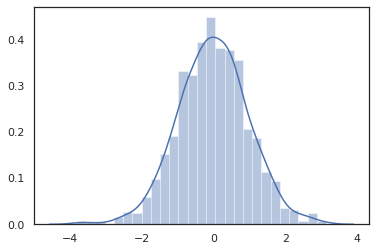

In [0]:
sns.distplot(tfd.Normal(0., 1.).sample(1000, seed=random.PRNGKey(0)))
plt.show()

`Distribution` methods are compatible with JAX transformations.

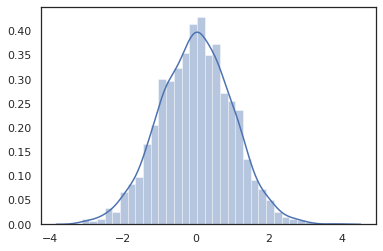

In [0]:
sns.distplot(jit(vmap(lambda key: tfd.Normal(0., 1.).sample(seed=key)))(
    random.split(random.PRNGKey(0), 2000)))
plt.show()

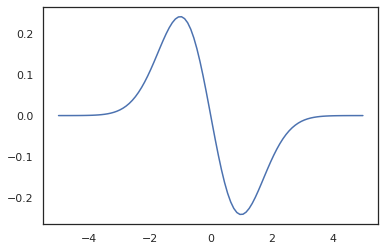

In [0]:
x = jnp.linspace(-5., 5., 100)
plt.plot(x, jit(vmap(grad(tfd.Normal(0., 1.).prob)))(x))
plt.show()

Because TFP distributions are registered as JAX pytree nodes, we can write functions with distributions as inputs or outputs and transform them using `jit`, but they are not yet supported as arguments to `vmap`-ed functions.

In [0]:
@jit
def random_distribution(key):
  loc_key, scale_key = random.split(key)
  loc, log_scale = random.normal(loc_key), random.normal(scale_key)
  return tfd.Normal(loc, jnp.exp(log_scale))
random_dist = random_distribution(random.PRNGKey(0))
print(random_dist.mean(), random_dist.variance())

0.14389051 0.081832744


### Transformed distributions

Transformed distributions i.e. distributions whose samples are passed through a `Bijector` also work out of the box (bijectors work too! see below).

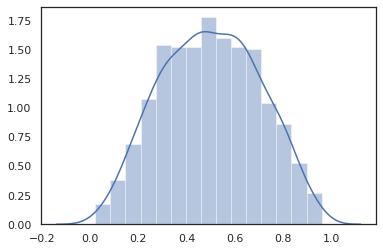

In [0]:
dist = tfd.TransformedDistribution(
    tfd.Normal(0., 1.),
    tfb.Sigmoid()
)
sns.distplot(dist.sample(1000, seed=random.PRNGKey(0)))
plt.show()

### Joint distributions

TFP offers `JointDistribution`s to enable combining component distributions into a single distribution over multiple random variables. Currently, TFP offers three core variants (`JointDistributionSequential`, `JointDistributionNamed`, and `JointDistributionCoroutine`) all of which are supported in JAX. The `AutoBatched` variants are also all supported.

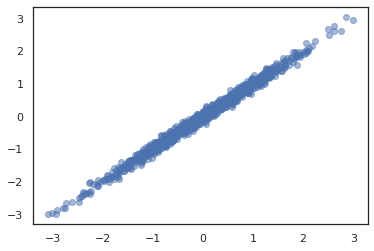

In [0]:
dist = tfd.JointDistributionSequential([
  tfd.Normal(0., 1.),
  lambda x: tfd.Normal(x, 1e-1)
])
plt.scatter(*dist.sample(1000, seed=random.PRNGKey(0)), alpha=0.5)
plt.show()

In [0]:
joint = tfd.JointDistributionNamed(dict(
    e=             tfd.Exponential(rate=1.),
    n=             tfd.Normal(loc=0., scale=2.),
    m=lambda n, e: tfd.Normal(loc=n, scale=e),
    x=lambda    m: tfd.Sample(tfd.Bernoulli(logits=m), 12),
))
joint.sample(seed=random.PRNGKey(0))

{'e': DeviceArray(3.376818, dtype=float32),
 'm': DeviceArray(2.5449684, dtype=float32),
 'n': DeviceArray(-0.6027825, dtype=float32),
 'x': DeviceArray([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)}

In [0]:
Root = tfd.JointDistributionCoroutine.Root
def model():
  e = yield Root(tfd.Exponential(rate=1.))
  n = yield Root(tfd.Normal(loc=0, scale=2.))
  m = yield tfd.Normal(loc=n, scale=e)
  x = yield tfd.Sample(tfd.Bernoulli(logits=m), 12)

joint = tfd.JointDistributionCoroutine(model)

joint.sample(seed=random.PRNGKey(0))

StructTuple(var0=DeviceArray(0.17315261, dtype=float32), var1=DeviceArray(-3.290489, dtype=float32), var2=DeviceArray(-3.1949058, dtype=float32), var3=DeviceArray([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32))

### Other distributions

Gaussian processes also work in JAX mode!

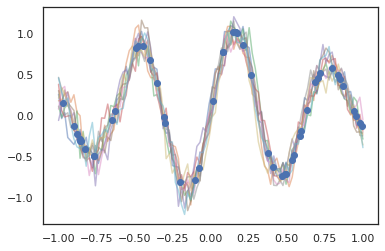

In [0]:
k1, k2, k3 = random.split(random.PRNGKey(0), 3)
observation_noise_variance = 0.01
f = lambda x: jnp.sin(10*x[..., 0]) * jnp.exp(-x[..., 0]**2)
observation_index_points = random.uniform(
    k1, [50], minval=-1.,maxval= 1.)[..., jnp.newaxis]
observations = f(observation_index_points) + tfd.Normal(
    loc=0., scale=jnp.sqrt(observation_noise_variance)).sample(seed=k2)

index_points = jnp.linspace(-1., 1., 100)[..., jnp.newaxis]

kernel = tfpk.ExponentiatedQuadratic(length_scale=0.1)

gprm = tfd.GaussianProcessRegressionModel(
    kernel=kernel,
    index_points=index_points,
    observation_index_points=observation_index_points,
    observations=observations,
    observation_noise_variance=observation_noise_variance)

samples = gprm.sample(10, seed=k3)
for i in range(10):
  plt.plot(index_points, samples[i], alpha=0.5)
plt.plot(observation_index_points, observations, marker='o', linestyle='')
plt.show()

Hidden Markov models are also supported.

In [0]:
initial_distribution = tfd.Categorical(probs=[0.8, 0.2])
transition_distribution = tfd.Categorical(probs=[[0.7, 0.3],
                                                 [0.2, 0.8]])

observation_distribution = tfd.Normal(loc=[0., 15.], scale=[5., 10.])

model = tfd.HiddenMarkovModel(
    initial_distribution=initial_distribution,
    transition_distribution=transition_distribution,
    observation_distribution=observation_distribution,
    num_steps=7)

print(model.mean())
print(model.log_prob(jnp.zeros(7)))
print(model.sample(seed=random.PRNGKey(0)))

[3.       6.       7.5      8.249999 8.625001 8.812501 8.90625 ]


/usr/local/lib/python3.6/dist-packages/tensorflow_probability/substrates/jax/distributions/hidden_markov_model.py:483: UserWarning: HiddenMarkovModel.log_prob in TFP versions < 0.12.0 had a bug in which the transition model was applied prior to the initial step. This bug has been fixed. You may observe a slight change in behavior.
  'HiddenMarkovModel.log_prob in TFP versions < 0.12.0 had a bug '


-19.855635
[ 1.3641367  0.505798   1.3626463  3.6541772  2.272286  15.10309
 22.794212 ]


A few distributions like `PixelCNN` are not supported yet due to strict dependencies on TensorFlow or XLA incompatibilities.

## Bijectors

Most of TFP's bijectors are supported in JAX today!

In [0]:
tfb.Exp().inverse(1.)

DeviceArray(0., dtype=float32)

In [0]:
bij = tfb.Shift(1.)(tfb.Scale(3.))
print(bij.forward(jnp.ones(5)))
print(bij.inverse(jnp.ones(5)))

[4. 4. 4. 4. 4.]
[0. 0. 0. 0. 0.]


In [0]:
b = tfb.FillScaleTriL(diag_bijector=tfb.Exp(), diag_shift=None)
print(b.forward(x=[0., 0., 0.]))
print(b.inverse(y=[[1., 0], [.5, 2]]))

[[1. 0.]
 [0. 1.]]
[0.6931472 0.5       0.       ]


In [0]:
b = tfb.Chain([tfb.Exp(), tfb.Softplus()])
# or:
# b = tfb.Exp()(tfb.Softplus())
print(b.forward(-jnp.ones(5)))

[1.3678794 1.3678794 1.3678794 1.3678794 1.3678794]


Bijectors are compatible with JAX transformations like `jit`, `grad` and `vmap`.

In [0]:
jit(vmap(tfb.Exp().inverse))(jnp.arange(4.))

DeviceArray([     -inf, 0.       , 0.6931472, 1.0986123], dtype=float32)

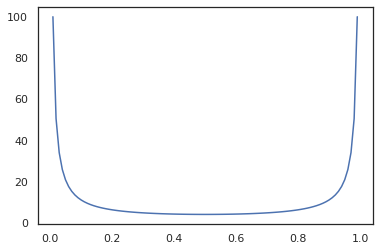

In [0]:
x = jnp.linspace(0., 1., 100)
plt.plot(x, jit(grad(lambda x: vmap(tfb.Sigmoid().inverse)(x).sum()))(x))
plt.show()

Some bijectors, like `RealNVP` and `FFJORD` are not yet supported.

## MCMC

We've ported `tfp.mcmc` to JAX as well, so we can run algorithms like Hamiltonian Monte Carlo (HMC) and the No-U-Turn-Sampler (NUTS) in JAX.

In [0]:
target_log_prob = tfd.MultivariateNormalDiag(jnp.zeros(2), jnp.ones(2)).log_prob

Unlike TFP on TF, we are required to pass a `PRNGKey` into `sample_chain` using the `seed` keyword argument.

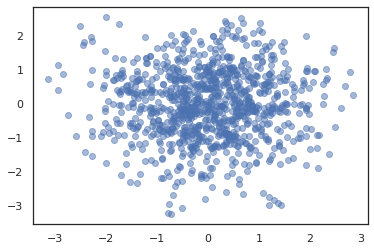

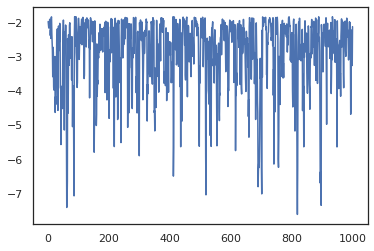

In [0]:
def run_chain(key, state):
  kernel = tfp.mcmc.NoUTurnSampler(target_log_prob, 1e-1)
  return tfp.mcmc.sample_chain(1000,
      current_state=state,
      kernel=kernel,
      trace_fn=lambda _, results: results.target_log_prob,
      seed=key)
states, log_probs = jit(run_chain)(random.PRNGKey(0), jnp.zeros(2))
plt.figure()
plt.scatter(*states.T, alpha=0.5)
plt.figure()
plt.plot(log_probs)
plt.show()

To run multiple chains, we can either pass a batch of states into `sample_chain` or use `vmap` (though we have not yet explored performance differences between the two approaches).

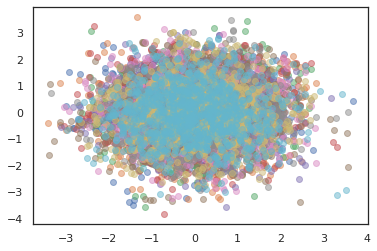

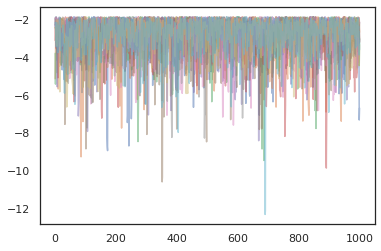

In [0]:
states, log_probs = jit(run_chain)(random.PRNGKey(0), jnp.zeros([10, 2]))
plt.figure()
for i in range(10):
  plt.scatter(*states[:, i].T, alpha=0.5)
plt.figure()
for i in range(10):
  plt.plot(log_probs[:, i], alpha=0.5)
plt.show()

## Optimizers

TFP on JAX supports some important optimizers like BFGS and L-BFGS. Let's set up a simple scaled quadratic loss function.

In [0]:
minimum = jnp.array([1.0, 1.0])  # The center of the quadratic bowl.
scales = jnp.array([2.0, 3.0])  # The scales along the two axes.

# The objective function and the gradient.
def quadratic_loss(x):
  return jnp.sum(scales * jnp.square(x - minimum))

start = jnp.array([0.6, 0.8])  # Starting point for the search.

BFGS can find the minimum of this loss.

In [0]:
optim_results = tfp.optimizer.bfgs_minimize(
    value_and_grad(quadratic_loss), initial_position=start, tolerance=1e-8)

# Check that the search converged
assert(optim_results.converged)
# Check that the argmin is close to the actual value.
np.testing.assert_allclose(optim_results.position, minimum)
# Print out the total number of function evaluations it took. Should be 5.
print("Function evaluations: %d" % optim_results.num_objective_evaluations)

Function evaluations: 5


So can L-BFGS.

In [0]:
optim_results = tfp.optimizer.lbfgs_minimize(
    value_and_grad(quadratic_loss), initial_position=start, tolerance=1e-8)

# Check that the search converged
assert(optim_results.converged)
# Check that the argmin is close to the actual value.
np.testing.assert_allclose(optim_results.position, minimum)
# Print out the total number of function evaluations it took. Should be 5.
print("Function evaluations: %d" % optim_results.num_objective_evaluations)

Function evaluations: 5


To `vmap` L-BFGS, let's set up a function that optimizes the loss for a single starting point.

In [0]:
def optimize_single(start):
  return tfp.optimizer.lbfgs_minimize(
      value_and_grad(quadratic_loss), initial_position=start, tolerance=1e-8)

all_results = jit(vmap(optimize_single))(
    random.normal(random.PRNGKey(0), (10, 2)))
assert all(all_results.converged)
for i in range(10):
  np.testing.assert_allclose(optim_results.position[i], minimum)
print("Function evaluations: %s" % all_results.num_objective_evaluations)

Function evaluations: [6 6 9 6 6 8 6 8 5 9]


## Caveats

There are some fundamental differences between TF and JAX, some TFP behaviors will be different between the two substrates and not all functionality is supported. For example,


*   TFP on JAX does not support anything like `tf.Variable` since nothing like it exists in JAX. This also means utilities like `tfp.util.TransformedVariable` are not supported either.
*  `tfp.layers` is not supported in the backend yet, due to its dependence on Keras and `tf.Variable`s.
*  `tfp.math.minimize` does not work in TFP on JAX because of its dependence  on `tf.Variable`.
*   With TFP on JAX, tensor shapes are always concrete integer values and are never unknown/dynamic as in TFP on TF.
*   Pseudorandomness is handled differently in TF and JAX (see appendix).
*  Libraries in `tfp.experimental` are not guaranteed to exist in the JAX substrate.
*  Dtype promotion rules are different between TF and JAX. TFP on JAX tries to respect TF's dtype semantics internally, for consistency.
*  Bijectors have not yet been registered as JAX pytrees.


To see the complete list of what is supported in TFP on JAX, please refer to the [API documentation](https://www.tensorflow.org/probability/api_docs/python/tfp/substrates/jax).

## Conclusion

We've ported a lot of TFP's features to JAX and are excited to see what everyone will build. Some functionality is not yet supported; if we've missed something important to you (or if you find a bug!) please reach out to us -- you can email [tfprobability@tensorflow.org](mailto:tfprobability@tensorflow.org) or file an issue on [our Github repo](https://github.com/tensorflow/probability).

## Appendix: pseudorandomness in JAX

JAX's pseudorandom number generation (PRNG) model is *stateless*. Unlike a stateful model, there is no mutable global state that evolves after each random draw. In JAX's model, we start with a PRNG *key*, which acts like a pair of 32-bit integers. We can construct these keys by using `jax.random.PRNGKey`.

In [0]:
key = random.PRNGKey(0)  # Creates a key with value [0, 0]
print(key)

[0 0]


Random functions in JAX consume a key to *deterministically* produce a random variate, meaning they should not be used again. For example, we can use `key` to sample a normally distributed value, but we should not use `key` again elsewhere. Furthermore, passing the same value into `random.normal` will produce the same value.

In [0]:
print(random.normal(key))

-0.20584226


So how do we ever draw multiple samples from a single key? The answer is *key splitting*. The basic idea is that we can split a `PRNGKey` into multiple, and each of the new keys can be treated as an independent source of randomness.

In [0]:
key1, key2 = random.split(key, num=2)
print(key1, key2)

[4146024105  967050713] [2718843009 1272950319]


Key splitting is deterministic but is chaotic, so each new key can now be used to draw a distinct random sample.

In [0]:
print(random.normal(key1), random.normal(key2))

0.14389051 -1.2515389


For more details about JAX's deterministic key splitting model, see [this guide](https://github.com/google/jax/blob/master/design_notes/prng.md).